# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Read data

In [2]:
data = pd.read_csv("../dataset/Clean_data.csv")

In [3]:
data.head()

,label,Account type,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Savings type,Length of current employment,Instalment per cent,Marital Status,Guarantors,Duration in Current address,Most valuable available asset,Age,Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Foreign Worker
0,1,1,18.0,4,2,1049.0,1,2,4,2,1,4,2,21.0,3,1,1,3,1,1
1,1,1,9.0,4,0,2799.0,1,3,2,3,1,2,1,36.0,3,1,2,3,2,1
2,1,2,12.0,2,9,841.0,2,4,2,2,1,4,1,23.0,3,1,1,2,1,1
3,1,1,12.0,4,0,2122.0,1,3,3,3,1,2,1,39.0,3,1,2,2,2,2
4,1,1,12.0,4,0,2171.0,1,3,4,3,1,4,2,38.0,1,2,2,2,1,2


In [4]:
data.dtypes

label                                  int64
Account type                           int64
Duration of Credit (month)           float64
Payment Status of Previous Credit      int64
Purpose                                int64
Credit Amount                        float64
Savings type                           int64
Length of current employment           int64
Instalment per cent                    int64
Marital Status                         int64
Guarantors                             int64
Duration in Current address            int64
Most valuable available asset          int64
Age                                  float64
Concurrent Credits                     int64
Type of apartment                      int64
No of Credits at this Bank             int64
Occupation                             int64
No of dependents                       int64
Foreign Worker                         int64
dtype: object

## Data Transformation

In [5]:
# import transformers and column transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [6]:
# convert nominal categorical features to object data type
nominal_cols = ["Account type","Purpose","Savings type","Type of apartment",
               "Marital Status","Occupation","Foreign Worker"]

In [7]:
for feature in nominal_cols:
    data[feature] = data[feature].astype(object)

In [8]:
def transform_data(dataframe, target):
    df = dataframe.drop([target], axis =1)
    
    numerical_features = df.select_dtypes(exclude = "object").columns.to_list()
    categorical_features = df.select_dtypes(include = "object").columns.to_list()
    
    # Transformers
    numerical_transformer = MinMaxScaler()
    categorical_transformer = OneHotEncoder(drop = 'if_binary')
    
    # define column transformer object
    pipeline = ColumnTransformer(
    [
       ( "numerical transformer", numerical_transformer, numerical_features),
        ("categorical transformer", categorical_transformer, categorical_features)
    ])
    
    # apply transformer
    transformed_array = pipeline.fit_transform(df)
    
    # Get the transformed column names
    transformed_numerical_columns = pipeline.transformers_[0][2]
    transformed_categorical_columns = pipeline.transformers_[1][1].get_feature_names_out(input_features=categorical_features)
    
    # Combine numerical and categorical transformed column names
    transformed_column_names = list(transformed_numerical_columns) + list(transformed_categorical_columns)
    
    # convert array to dataframe
    transformed_data = pd.DataFrame(transformed_array, columns=transformed_column_names)
    
    # attach target feature
    transformed_data[target] = dataframe[target]
    
    return transformed_data

In [9]:
transformed_df = transform_data(dataframe=data, target="label")

In [10]:
transformed_df.head(1)

,Duration of Credit (month),Payment Status of Previous Credit,Credit Amount,Length of current employment,Instalment per cent,Guarantors,Duration in Current address,Most valuable available asset,Age,Concurrent Credits,...,Marital Status_4,Type of apartment_1,Type of apartment_2,Type of apartment_3,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Foreign Worker_2,label
0,0.368421,1.0,0.104686,0.25,1.0,0.0,1.0,0.333333,0.043956,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [11]:
transformed_df.shape

(1000, 44)

## Modeling

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

In [13]:
# write a function to search for baseline model

def base_line_model(data_frame, target):
    #split data into X and y
    X_data = data_frame.drop([target],axis = 1)
    y_data = data_frame[target]

    # Assuming X and y into train and test, add stratify = y_data to make sure the imbalance nature of target is considered
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42, stratify=y_data)


    # Define classifiers
    classifiers = {
        'Logistics Regression': LogisticRegression(),
        'Decision tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier()
    }

    # FIT models
    for classifier_name, classifier in classifiers.items():
        precision = []
        recall = []
        accuracy = []
        f1 = []
        print(f"\nResults for {classifier_name}:\n")

        # Train the classifier
        clss = classifier
        clss.fit(X_train, y_train)

        # Make predictions on Train
        y_train_pred = clss.predict(X_train)

        # Make predictions on Test
        y_pred = clss.predict(X_test)

        # Train info: Calculate and print metrics
        Train_accuracy = accuracy_score(y_train, y_train_pred)
        Train_precision = precision_score(y_train, y_train_pred)
        Train_recall = recall_score(y_train, y_train_pred)
        Train_f1 = f1_score(y_train, y_train_pred)


        # Test info: Calculate and print metrics
        Test_accuracy = accuracy_score(y_test, y_pred)
        Test_precision = precision_score(y_test, y_pred)
        Test_recall = recall_score(y_test, y_pred)
        Test_f1 = f1_score(y_test, y_pred)

        # print train result
        print(f"\n Results from Train:")
        print(f"Accuracy: {Train_accuracy:.4f}")
        
        print(f"Precision: {Train_precision:.4f}")
        print(f"Recall: {Train_recall:.4f}")
        print(f"F1 Score: {Train_f1:.4f}")

        # print test result
        print(f"\n Results from Test:")
        print(f"Accuracy: {Test_accuracy:.4f}")
        print(f"Precision: {Test_precision:.4f}")
        print(f"Recall: {Test_recall:.4f}")
        print(f"F1 Score: {Test_f1:.4f}")

In [14]:
base_line_model(data_frame=transformed_df, target="label")


Results for Logistics Regression:


 Results from Train:
Accuracy: 0.7743
Precision: 0.8051
Recall: 0.8939
F1 Score: 0.8472

 Results from Test:
Accuracy: 0.7800
Precision: 0.8130
Recall: 0.8905
F1 Score: 0.8500

Results for Decision tree:


 Results from Train:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

 Results from Test:
Accuracy: 0.7233
Precision: 0.8068
Recall: 0.7952
F1 Score: 0.8010

Results for Random Forest:


 Results from Train:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

 Results from Test:
Accuracy: 0.7900
Precision: 0.7952
Recall: 0.9429
F1 Score: 0.8627

Results for XGBoost:


 Results from Train:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

 Results from Test:
Accuracy: 0.7333
Precision: 0.7826
Recall: 0.8571
F1 Score: 0.8182


Based on the **F1 score**, which balances precision and recall, **Logistic Regression** is the best baseline model for this dataset. It shows strong **generalization** with the highest F1 score on the test set.

## Try PCA to reduce data dimension and noise

In [20]:
from sklearn.decomposition import PCA

In [16]:
transformed_df.head()

,Duration of Credit (month),Payment Status of Previous Credit,Credit Amount,Length of current employment,Instalment per cent,Guarantors,Duration in Current address,Most valuable available asset,Age,Concurrent Credits,...,Marital Status_4,Type of apartment_1,Type of apartment_2,Type of apartment_3,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Foreign Worker_2,label
0,0.368421,1.0,0.104686,0.25,1.000000,0.0,1.000000,0.333333,0.043956,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0.131579,1.0,0.333972,0.50,0.333333,0.0,0.333333,0.000000,0.373626,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,0.210526,0.5,0.077433,0.75,0.333333,0.0,1.000000,0.000000,0.087912,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
3,0.210526,1.0,0.245271,0.50,0.666667,0.0,0.333333,0.000000,0.439560,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
4,0.210526,1.0,0.251691,0.50,1.000000,0.0,1.000000,0.333333,0.417582,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1


In [34]:
def apply_pca(dataframe, target):

    df = dataframe.drop([target], axis = 1)
    num_features = df.shape[1]

    #initialize pca
    pca = PCA(n_components=num_features, random_state=360)

    #fit pca
    pca_array = pca.fit_transform(df)
    pca_df = pd.DataFrame(data = pca_array)
    pca_df[target] = dataframe[target]

    cumulative_variance  = np.cumsum(pca.explained_variance_ratio_)
    # Create the scree plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
    plt.title('Scree Plot of Cumulative Explained Variance')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()

    return pca_df

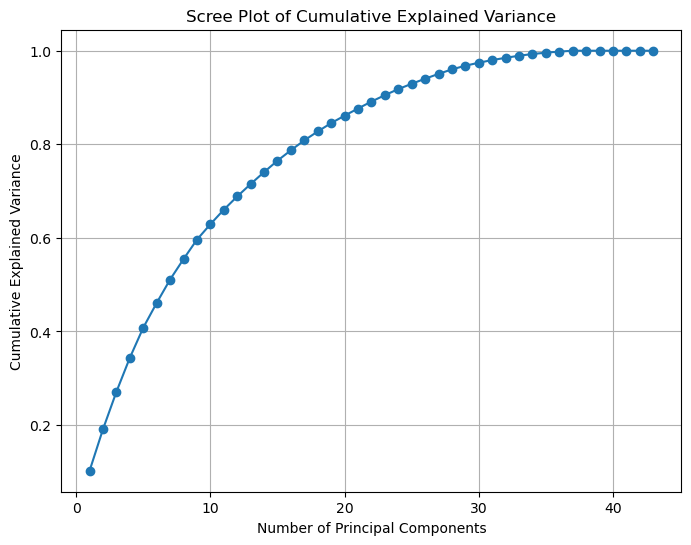

In [35]:
pca_df = apply_pca(dataframe=transformed_df, target="label")

In [36]:
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,label
0,1.556650,0.115212,0.681710,-0.722044,-0.477952,-0.116383,0.221853,0.104804,0.500982,-0.344755,...,-0.017927,0.037113,0.012255,-3.769096e-15,2.034714e-15,-1.287809e-15,-2.354250e-16,-6.065199e-16,4.849291e-17,1
1,0.259353,0.918476,0.298333,-0.641920,-0.511574,-0.801281,0.479230,-0.839677,-0.057703,0.730258,...,0.034234,0.035674,0.009088,-2.765604e-17,-7.264460e-16,2.345155e-16,-6.655165e-17,-5.787621e-16,1.451812e-16,1
2,1.129562,-0.086996,0.401984,1.477197,0.381188,-0.118001,0.680426,-0.552175,0.587919,-0.280699,...,-0.022125,0.021691,-0.023059,9.566056e-16,-3.466505e-16,3.807460e-16,-1.334690e-16,1.049480e-16,-1.415389e-17,1
3,0.307371,1.374611,-0.264378,0.301099,-0.975096,-0.660213,0.878099,-0.739719,0.091005,0.491596,...,0.032398,-0.003756,0.004307,-1.150636e-15,-4.139558e-17,5.642433e-16,-2.850619e-17,5.380652e-16,-1.482545e-16,1
4,-0.078828,1.172125,-0.874561,0.186841,-0.643660,-0.688864,0.349205,0.079297,-0.362228,-0.325694,...,-0.019572,-0.053476,0.020496,-5.819863e-16,-4.347757e-17,1.326809e-16,1.992668e-16,5.174770e-16,-1.254649e-16,1


In [37]:
pca_df = pca_df.drop(pca_df.columns[36:43], axis=1)

In [38]:
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,label
0,1.556650,0.115212,0.681710,-0.722044,-0.477952,-0.116383,0.221853,0.104804,0.500982,-0.344755,...,-0.081550,-0.155358,0.048806,-0.156509,0.065616,0.207932,0.016255,-0.017927,0.037113,1
1,0.259353,0.918476,0.298333,-0.641920,-0.511574,-0.801281,0.479230,-0.839677,-0.057703,0.730258,...,-0.269135,0.039806,-0.164420,-0.086049,-0.083628,0.071179,0.045065,0.034234,0.035674,1
2,1.129562,-0.086996,0.401984,1.477197,0.381188,-0.118001,0.680426,-0.552175,0.587919,-0.280699,...,-0.195096,-0.245922,0.016341,-0.042075,0.105331,0.086092,-0.011387,-0.022125,0.021691,1
3,0.307371,1.374611,-0.264378,0.301099,-0.975096,-0.660213,0.878099,-0.739719,0.091005,0.491596,...,-0.051626,0.153186,0.776176,-0.014906,-0.081314,-0.038380,-0.087021,0.032398,-0.003756,1
4,-0.078828,1.172125,-0.874561,0.186841,-0.643660,-0.688864,0.349205,0.079297,-0.362228,-0.325694,...,0.094548,-0.043025,0.892344,-0.021068,-0.097301,-0.077629,0.032718,-0.019572,-0.053476,1


In [39]:
base_line_model(data_frame=pca_df, target="label")


Results for Logistics Regression:


 Results from Train:
Accuracy: 0.7714
Precision: 0.8044
Recall: 0.8898
F1 Score: 0.8450

 Results from Test:
Accuracy: 0.7800
Precision: 0.8130
Recall: 0.8905
F1 Score: 0.8500

Results for Decision tree:


 Results from Train:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

 Results from Test:
Accuracy: 0.6633
Precision: 0.7659
Recall: 0.7476
F1 Score: 0.7566

Results for Random Forest:


 Results from Train:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

 Results from Test:
Accuracy: 0.7633
Precision: 0.7546
Recall: 0.9810
F1 Score: 0.8530

Results for XGBoost:


 Results from Train:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

 Results from Test:
Accuracy: 0.7867
Precision: 0.8042
Recall: 0.9190
F1 Score: 0.8578


- **Logistic Regression** is the best baseline model because it shows consistent and balanced performance across both training and test sets, with no signs of overfitting.

- **XGBoost** and **Random Forest** perform slightly better on the test set, especially in terms of recall and F1 score, but their perfect training scores indicate they **overfitting** the training data, which might cause issues in more complex or real-world scenarios.

**Its better to go for the less complex model (in this case logistics regression) because of the following:**
- Faster training time
- Easy interpretation
- Lesser risk of high variance
- Easy to tune and maintain
- etc.

In [ ]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]